In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [40]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA


In [41]:
df = pd.read_csv("/content/drive/MyDrive/Master/data/spectrums/all_average_spectra.csv")

In [42]:
df.drop(columns=["Unnamed: 0", "sample_id"], inplace=True)


In [43]:
df["class"] = df["class_y"].replace({"clean_kontroll": "control", "clean_tork": "drought"})
df.drop(columns=["class_y"], inplace=True)

In [44]:
df_mean = df.groupby(["class", "day"]).mean()
df_mean.reset_index(inplace=True)


In [46]:
def Classifier(df, pipeline):
  """
  Plots confusion matrix, and prints classification metrics
  Input:
  df: pandas DataFrame
  pipeline: sklearn pipeline
  Output:
  pred_df: pandas DataFrame with predictions
  """
  df = df.reset_index()
  feature_cols = [c for c in df.columns if c not in ['class', "label_simple"]]
  loo = LeaveOneOut()
  all_preds = []

  for train_idx, test_idx in loo.split(df):
      X_train = df.iloc[train_idx][feature_cols]
      y_train = df.iloc[train_idx]['class']

      X_test = df.iloc[test_idx][feature_cols]
      y_test = df.iloc[test_idx]['class']

      pipeline.fit(X_train, y_train)
      y_pred = pipeline.predict(X_test)

      fold_res = pd.DataFrame({
          'day': df.iloc[test_idx]['day'].values,
          'y_true': y_test.values,
          'y_pred': y_pred
      })
      all_preds.append(fold_res)

  pred_df = pd.concat(all_preds, ignore_index=True)


  classes = df["class"].unique()

  for d, sub in pred_df.groupby('day'):
      cm = confusion_matrix(sub['y_true'], sub['y_pred'], labels=classes)
      print(f"Precision (Day {d}):", precision_score(sub['y_true'], sub['y_pred'], average='macro'))
      print(f"Recall (Day {d}):", recall_score(sub['y_true'], sub['y_pred'], average='macro'))
      print(f"F1 Score (Day {d}):", f1_score(sub['y_true'], sub['y_pred'], average='macro'))
      disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
      disp.plot(cmap='Blues', values_format='d')
      plt.title(f"Control vs Infested vs Drought – Day {d}")
      plt.tight_layout()
      #plt.savefig(f"/content/drive/MyDrive/Master/data/plots/conf_matrix_day{d}_simple.png", dpi=1000)
      plt.show()


  cm = confusion_matrix(pred_df['y_true'], pred_df['y_pred'], labels=classes)
  print("Precision (Total):", precision_score(pred_df['y_true'], pred_df['y_pred'], average='macro'))
  print("Recall (Total:", recall_score(pred_df['y_true'], pred_df['y_pred'], average='macro'))
  print("F1 Score (Total):", f1_score(pred_df['y_true'], pred_df['y_pred'], average='macro'))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
  disp.plot(cmap='Blues', values_format='d')

  disp.ax_.tick_params(axis='y', labelsize=14)
  disp.ax_.tick_params(axis='x', labelsize=14, rotation=45)


  # Change axis labels
  disp.ax_.set_xlabel("Predicted label", fontsize=18)
  disp.ax_.set_ylabel("True label", fontsize=18)

  plt.title(f"Confusion matrix – Second derivative", fontsize=20)
  plt.tight_layout()
  #plt.savefig(f"/content/drive/MyDrive/Master/data/plots/conf_matrix_combined_sderiv_simple.png", dpi=400)
  plt.show()


## Five-class classification

In [47]:
# Define the pipeline
pipeline = Pipeline([
    ('preprocessor', StandardScaler()),
    ('lda', LDA(n_components=4)),
    ('classifier', RandomForestClassifier(random_state=6))
])

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision (Day 2): 0.4
Recall (Day 2): 0.6
F1 Score (Day 2): 0.4666666666666666


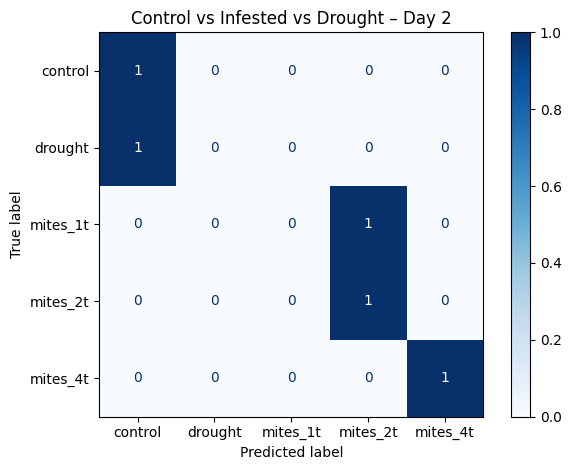

Precision (Day 5): 1.0
Recall (Day 5): 1.0
F1 Score (Day 5): 1.0


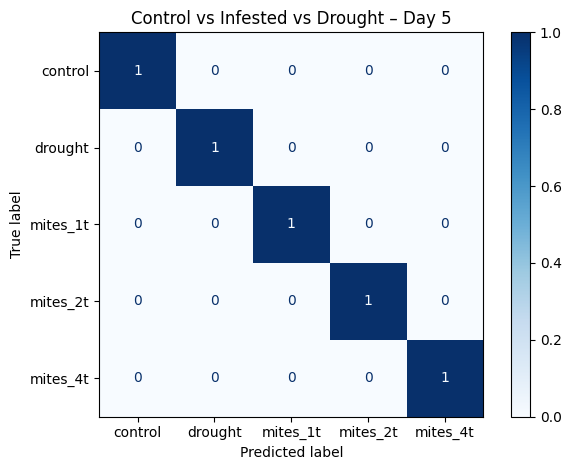

Precision (Day 7): 1.0
Recall (Day 7): 1.0
F1 Score (Day 7): 1.0


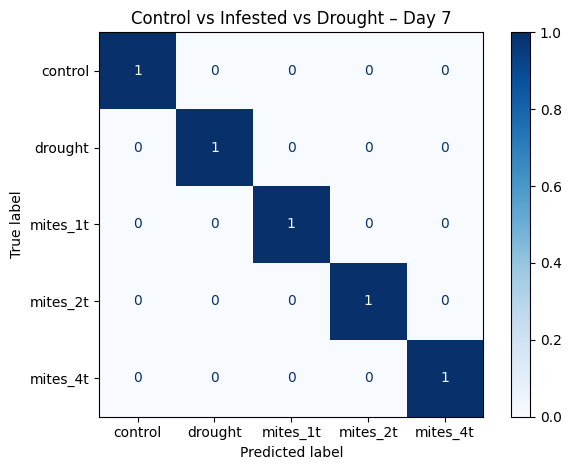

Precision (Day 9): 0.7
Recall (Day 9): 0.8
F1 Score (Day 9): 0.7333333333333333


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


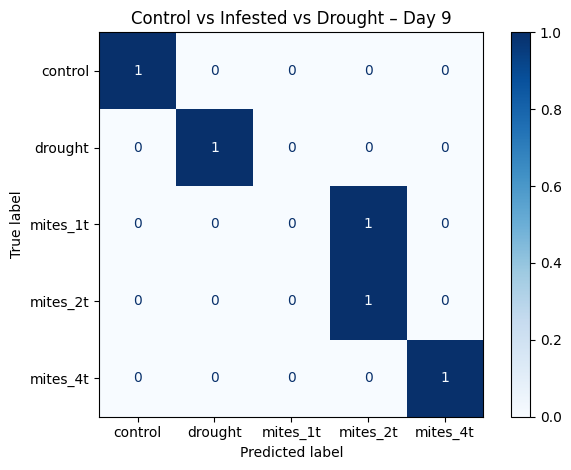

Precision (Total): 0.8933333333333333
Recall (Total: 0.85
F1 Score (Total): 0.8425396825396826


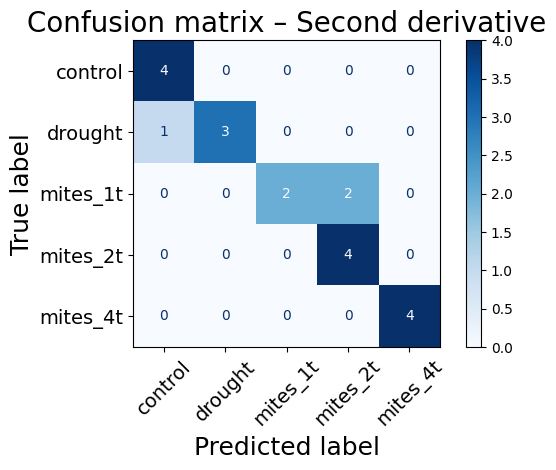

In [48]:
Classifier(df_mean, pipeline)

## Three-class Classification

In [49]:
def simplify_label(treatment):
    if 'mites' in treatment:
        return 'infested'
    elif 'drought' in treatment:
        return 'drought'
    elif 'control' in treatment:
        return 'control'
    else:
        return treatment
#df = df.reset_index()
df_simple = df_mean.copy()
df_simple['class'] = df_mean['class'].apply(simplify_label)

In [50]:
# Define the pipeline
pipeline = Pipeline([
    ('preprocessor', StandardScaler()),
    ('lda', LDA(n_components=2)),
    ('classifier', RandomForestClassifier(random_state=6))
])

Precision (Day 2): 0.5555555555555555
Recall (Day 2): 0.5555555555555555
F1 Score (Day 2): 0.5555555555555555


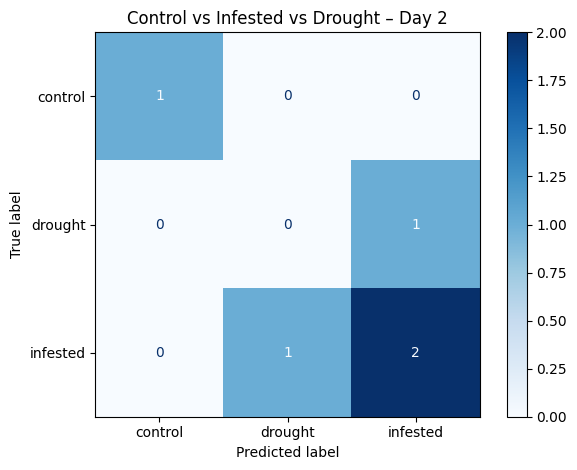

Precision (Day 5): 1.0
Recall (Day 5): 1.0
F1 Score (Day 5): 1.0


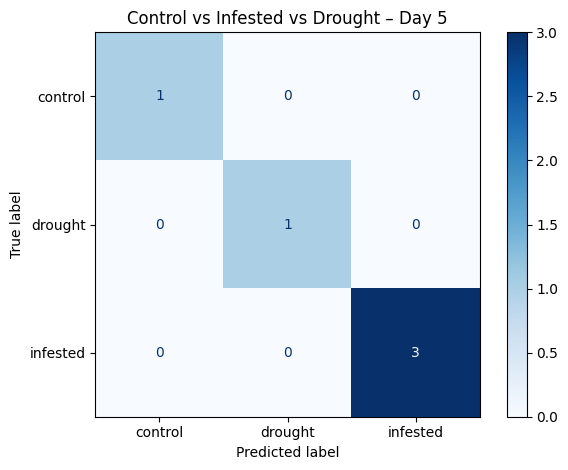

Precision (Day 7): 0.5833333333333334
Recall (Day 7): 0.6666666666666666
F1 Score (Day 7): 0.6190476190476191


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


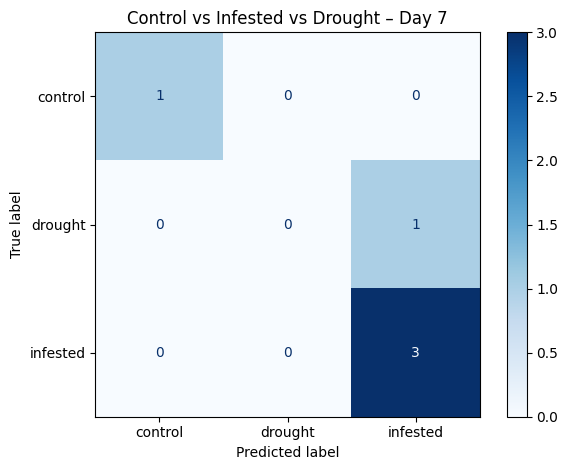

Precision (Day 9): 1.0
Recall (Day 9): 1.0
F1 Score (Day 9): 1.0


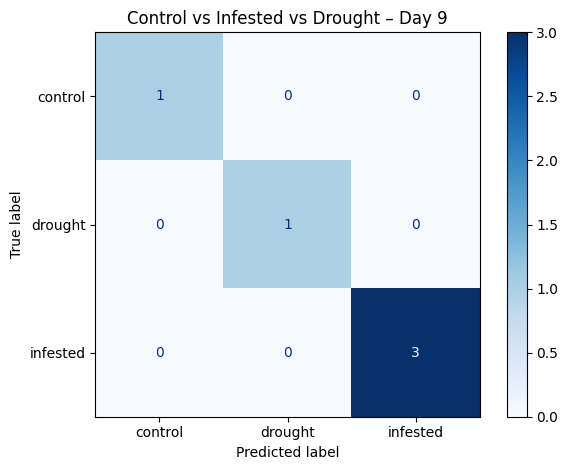

Precision (Total): 0.8376068376068376
Recall (Total: 0.8055555555555555
F1 Score (Total): 0.8171428571428572


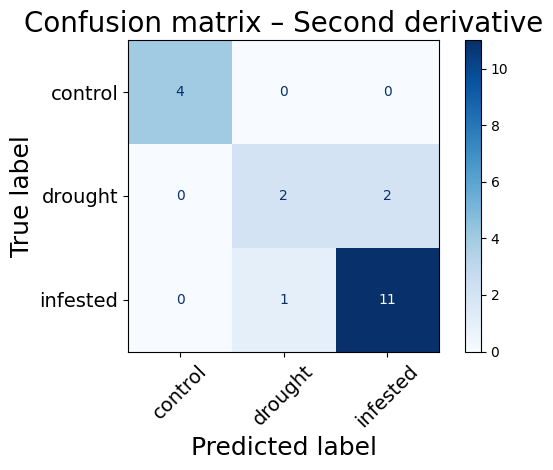

In [51]:
Classifier(df_simple, pipeline)